In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [4]:
db = conn['NCU_CHKA']
collection = db['chka_final_score']
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)

len(score_df)

128

In [8]:
db = conn['NCU_CHKA']
collection = db['chka_all_features_by_week']
feature_df = pd.DataFrame(list(collection.find()))
feature_df = feature_df.drop(['_id'], axis=1)

feature_df = feature_df.fillna('0')
#feature_df = df['final_score']
#feature_df = score_df.dropna()
#feature_df = feature_df.astype(float)

#feature_df = feature_df.groupby(['username']).mean()
feature_df.head(5)

,Cumulative_num_days,Problem_num_day,active_num_days,active_sum_count,homework_complete_num,homework_num,num_complete,num_watched,pause_video_sum,seek_video_sum,stop_video_sum,username,video_backward_seek_sum,video_forward_seek_sum,video_num_days,video_pause_sum,video_stop_sum,video_sum_count,week
0,0,0,3,318,0,0,0,4,4,3,0,Y1050160,3,6,3,9,0,25,2
1,0,0,2,2,0,0,0,0,0,0,0,Y1050161,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,0,Y1050161,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,Y1050161,0,0,0,0,0,0,5
4,0,0,1,231,0,0,0,0,0,0,0,Y1050161,0,0,0,0,0,0,2


In [20]:
ncu_ets = pd.merge(feature_df, score_df, on='username')
ncu_ets = ncu_ets.drop(['username'], axis=1)
ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['final_score'] < 60
ncu_ets = ncu_ets.drop(['final_score'], axis=1)
ncu_ets.head(5)

,Cumulative_num_days,Problem_num_day,active_num_days,active_sum_count,homework_complete_num,homework_num,num_complete,num_watched,pause_video_sum,seek_video_sum,stop_video_sum,video_backward_seek_sum,video_forward_seek_sum,video_num_days,video_pause_sum,video_stop_sum,video_sum_count,class
0,0.0,0.0,3.0,318.0,0.0,0.0,0.0,4.0,4.0,3.0,0.0,3.0,6.0,3.0,9.0,0.0,25.0,True
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,0.0,0.0,2.0,372.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,7.0,13.0,2.0,19.0,0.0,41.0,True
4,0.0,0.0,1.0,181.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,1.0,6.0,0.0,12.0,True


In [12]:
# Import some data to play with
#iris = datasets.load_iris()

#kyoto_y = kyoto_1['score']
#kyoto_x = kyoto_1.drop(['score'], axis=1)

X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3)
clf_binary = svm.SVC(kernel='linear', 
                     probability=True)
#classifier = svm.OneClassSVM(kernel='linear', probability=True,
#                     random_state=random_state)
clf_one = svm.OneClassSVM(kernel="sigmoid")


0
1
2


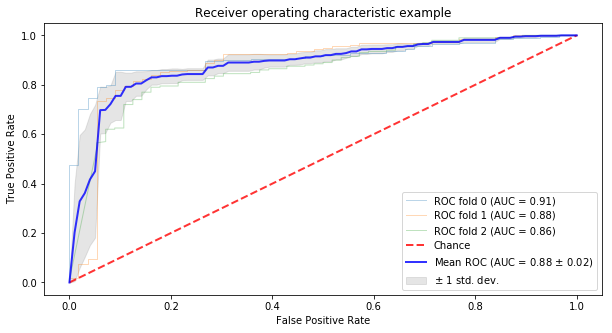

In [13]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 5))

i = 0
for train, test in cv.split(X, y):
    
    print(i)
    probas_ = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

0
1
2


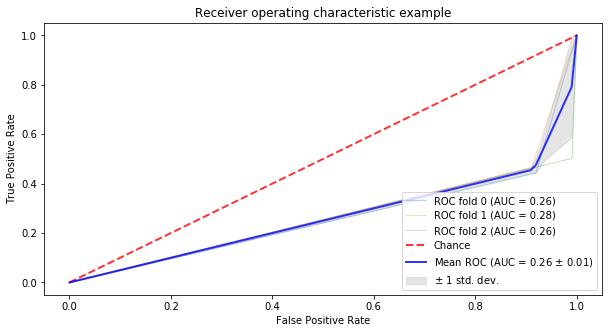

In [14]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 5))

i = 0
for train, test in cv.split(X, y):
    
    clf_one.fit(X[train])
    probas_ = clf_one.predict(X[train])

    
    print(i)
    #probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[train], probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

#X_train, X_test, y_train, y_test = train_test_split(kyoto_x, kyoto_y, test_size=0.3)

precision, recall, _ = precision_recall_curve(y[test], probas_[:, 1])
average_precision = average_precision_score(y[test], probas_[:, 1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(10, 5))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

IndexError: too many indices for array